###Installing Dependencies

In [ ]:
!pip install tensorflow numpy pandas datasets nltk

###Importing Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datasets import load_dataset
import re
from nltk.tokenize import sent_tokenize
import nltk
import os

# Download NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

###Enabling Mixed Precision Training
This cell enables mixed precision training, which uses both 16-bit and 32-bit
floating-point types to speed up training and reduce memory usage.

In [ ]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

### Custom Perplexity Metric

In [ ]:
# Part 2: Custom Perplexity Metric
class Perplexity(tf.keras.metrics.Metric):
    def __init__(self, name='perplexity', **kwargs):
        super(Perplexity, self).__init__(name=name, **kwargs)
        self.loss_sum = self.add_weight(name='loss_sum', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
        masked_loss = loss * mask
        self.loss_sum.assign_add(tf.reduce_sum(masked_loss))
        self.count.assign_add(tf.reduce_sum(mask))

    def result(self):
        return tf.exp(self.loss_sum / self.count)

    def reset_state(self):
        self.loss_sum.assign(0.0)
        self.count.assign(0.0)

###Text Cleaning Function

In [ ]:
# Part 3: Data Loading and Preprocessing
def clean_text(text):
    text = re.sub(r'[^\w\s.,!?]', '', text)  # Keep alphanumeric, spaces, punctuation
    text = re.sub(r'\b\d+\b', '', text)  # Remove standalone numbers
    text = text.replace('co2', 'carbon dioxide')  # Normalize scientific terms
    text = text.lower()  # Normalize to lowercase
    text = ' '.join(text.split())  # Remove extra whitespace
    return text

###Loading Datasets and Text Processing

In [ ]:
physics_url = "https://huggingface.co/datasets/camel-ai/physics/resolve/refs%2Fconvert%2Fparquet/default/train/0000.parquet"
chemistry_url = "https://huggingface.co/datasets/camel-ai/chemistry/resolve/refs%2Fconvert%2Fparquet/default/train/0000.parquet"
biology_url = "https://huggingface.co/datasets/camel-ai/biology/resolve/refs%2Fconvert%2Fparquet/default/train/0000.parquet"

# Physics dataset
phy_data = load_dataset("parquet", data_files={"train": physics_url}, split="train")
phy_texts = [clean_text(item['message_2']) for item in phy_data]

# Chemistry dataset
chem_data = load_dataset("parquet", data_files={"train": chemistry_url}, split="train")
chem_texts = [clean_text(item['message_2']) for item in chem_data]

# Biology dataset
bio_data = load_dataset("parquet", data_files={"train": biology_url}, split="train")
bio_texts = [clean_text(item['message_2']) for item in bio_data]

In [ ]:
# Split into sentences
texts = []
for text in phy_texts + chem_texts + bio_texts:
    sentences = sent_tokenize(str(text))
    texts.extend([s.strip() for s in sentences if s.strip()])

# Inspect data
print("Sample Physics texts:", phy_texts[:5])
print("Sample Chemistry texts:", chem_texts[:5])
print("Sample Biology texts:", bio_texts[:5])
print("Total texts:", len(texts))

Sample Physics texts: ['to find the probability of finding a particle with a given energy in a onedimensional infinite square well potential, we first need to solve the schrödinger equation for the allowed energy states and their wave functions. the timeindependent schrödinger equation for a onedimensional infinite square well potential is given by ħ2 2m d2ψx dx2 e ψx where ħ is the reduced planck constant . js, m is the mass of the particle kg, e is the energy of the particle, and ψx is the wave function. the boundary conditions for the infinite square well potential are ψ0 and ψa where a is the width of the well nm m. the general solution to the schrödinger equation is ψx a sinkx b coskx where a and b are constants, and k sqrt2me ħ. applying the boundary conditions ψ0 a sin0 b cos0 b ψa a sinka since a cannot be zero otherwise the wave function would be trivial, sinka must be zero. this occurs when ka nπ, where n is an integer , , , .... therefore, the allowed wave numbers are k_n nπ

###Tokenization and Sequence Generation

In [ ]:
# Create corpus and tokenize
tokenizer = Tokenizer(num_words=15000)
science_corpus = " ".join(texts)
tokenizer.fit_on_texts([science_corpus])
total_words = min(len(tokenizer.word_index) + 1, 15000)

In [ ]:
# Generate sequences
input_sequences = []
max_seq_len = 256
for line in texts:
    token_list = tokenizer.texts_to_sequences([line])[0]
    if token_list and len(token_list) > 0:
        if len(token_list) > max_seq_len:
            token_list = token_list[:max_seq_len]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

# Pad sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre'))
X = input_sequences[:,:-1]
y = input_sequences[:,-1]
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Vocabulary size: {total_words}")

X shape: (19345385, 255)
y shape: (19345385,)
Vocabulary size: 15000


###Model Building

In [ ]:
def build_model(vocab_size, max_sequence_length):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=256, input_shape=(max_sequence_length-1,)),
        tf.keras.layers.LSTM(192, return_sequences=True, recurrent_initializer='glorot_uniform'),   # First LSTM
        tf.keras.layers.GRU(192, return_sequences=False, recurrent_initializer='glorot_uniform'),   # Second GRU
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.Dense(128, activation='gelu'),
        tf.keras.layers.Dense(vocab_size, activation='softmax', dtype='float32')
    ])

    optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-4, clipnorm=1.0)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy', Perplexity()]
    )
    return model

In [ ]:
model = build_model(total_words, max_seq_len)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 255, 256)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 255, 192)       │       344,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 192)            │       222,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 192)            │           384 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 15000)          │     1,935,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,367,256 (24.29 MB)

 Trainable params: 6,367,256 (24.29 MB)

 Non-trainable params: 0 (0.00 B)

###Training the Model

In [ ]:
# Part 5: Training
history = model.fit(
    X, y,
    epochs=30,
    batch_size=2048,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_perplexity', patience=3, mode='min'),
        tf.keras.callbacks.ModelCheckpoint('best_science_gen_model.keras',
                                          monitor='val_perplexity',
                                          save_best_only=True,
                                          mode='min'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_perplexity', factor=0.2, patience=1)
    ]
)

Epoch 1/30
8502/8502 ━━━━━━━━━━━━━━━━━━━━ 759s 89ms/step - accuracy: 0.2443 - loss: 4.9344 - perplexity: 234.0601 - val_accuracy: 0.3003 - val_loss: 4.8780 - val_perplexity: 131.3643 - learning_rate: 5.0000e-04
Epoch 2/30
8502/8502 ━━━━━━━━━━━━━━━━━━━━ 777s 91ms/step - accuracy: 0.3627 - loss: 3.4591 - perplexity: 31.8109 - val_accuracy: 0.3180 - val_loss: 4.6640 - val_perplexity: 106.0592 - learning_rate: 5.0000e-04
Epoch 3/30
8502/8502 ━━━━━━━━━━━━━━━━━━━━ 771s 91ms/step - accuracy: 0.3884 - loss: 3.2245 - perplexity: 25.1425 - val_accuracy: 0.3292 - val_loss: 4.6051 - val_perplexity: 99.9893 - learning_rate: 5.0000e-04
Epoch 4/30
8502/8502 ━━━━━━━━━━━━━━━━━━━━ 752s 88ms/step - accuracy: 0.4035 - loss: 3.0990 - perplexity: 22.1755 - val_accuracy: 0.3334 - val_loss: 4.5157 - val_perplexity: 91.4459 - learning_rate: 5.0000e-04
Epoch 5/30
8502/8502 ━━━━━━━━━━━━━━━━━━━━ 773s 91ms/step - accuracy: 0.4143 - loss: 3.0162 - perplexity: 20.4128 - val_accuracy: 0.3384 - val_loss: 4.4889 - val_

###Plot the training graphs

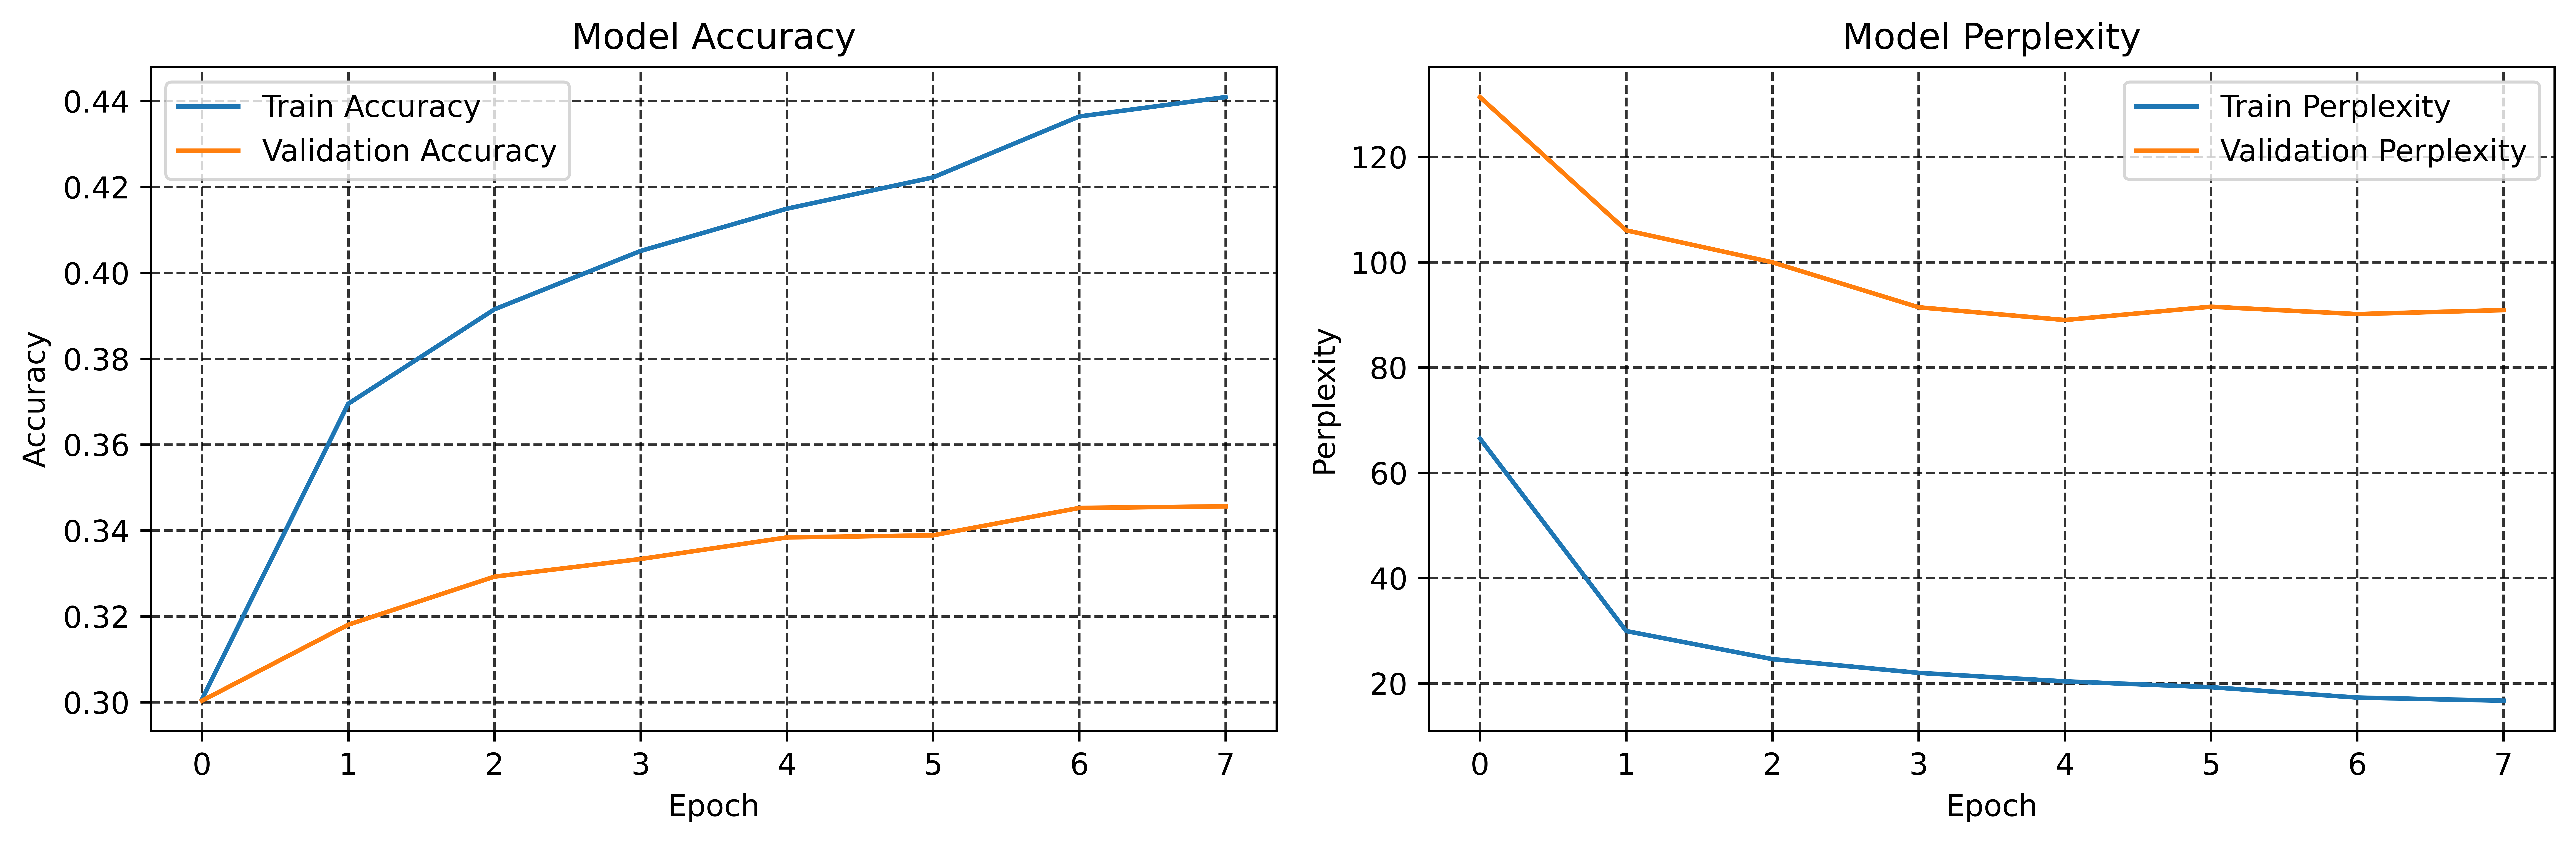

In [ ]:
plt.figure(figsize=(12, 4), dpi=1000)

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', color='black', alpha=0.8)

plt.subplot(1, 2, 2)
plt.plot(history.history['perplexity'], label='Train Perplexity')
plt.plot(history.history['val_perplexity'], label='Validation Perplexity')
plt.title('Model Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True, linestyle='--', color='black', alpha=0.8)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

###Sample Text Generation with Top-k Sampling

In [ ]:
# Part 7: Text Generation with Top-k Sampling
def generate_text(seed_text, next_words, model, tokenizer, max_sequence_length, k=10, temperature=0.9):
    """
    Generate text using top-k sampling for science text.

    Args:
        seed_text (str): Initial text (e.g., from SciQ questions).
        next_words (int): Number of words to generate.
        model: Trained LSTM model.
        tokenizer: Fitted tokenizer.
        max_sequence_length (int): Max sequence length used in training.
        k (int): Number of top probable words to sample from (default: 10).
        temperature (float): Controls randomness (0.9 for diversity).

    Returns:
        str: Generated text.
    """
    recent_words = set()
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)[0]

        # Temperature scaling
        scaled_probs = np.log(predicted_probs + 1e-10) / temperature
        exp_probs = np.exp(scaled_probs)
        normalized_probs = exp_probs / np.sum(exp_probs)

        # Top-k sampling with repetition prevention
        top_k_indices = np.argsort(normalized_probs)[-k:]
        top_k_probs = normalized_probs[top_k_indices]
        top_k_probs = top_k_probs / np.sum(top_k_probs)

        predicted_word_index = np.random.choice(top_k_indices, p=top_k_probs)

        # Avoid recent words
        attempts = 0
        while predicted_word_index in recent_words and attempts < 5:
            predicted_word_index = np.random.choice(top_k_indices, p=top_k_probs)
            attempts += 1

        recent_words.add(predicted_word_index)
        if len(recent_words) > 10:
            recent_words.pop()

        # Convert index to word
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_word_index:
                output_word = word
                break

        seed_text += " " + output_word

    return seed_text

In [ ]:
# Part 8: Test Generation
example_texts = [
    "The gravitational force between two objects",
    "Chemical reactions involve",
    "The structure of DNA consists of",
    "All radioactive decay is dangerous"
]

for text in example_texts:
    generated_text = generate_text(
        seed_text=text,
        next_words=20,
        model=model,
        tokenizer=tokenizer,
        max_sequence_length=256,
        k=10,
        temperature=0.9
    )
    print(f"Seed: {text}...")
    print(f"Generated: {generated_text}")
    print("-" * 50)

Seed: The gravitational force between two objects...
Generated: The gravitational force between two objects is described by the einstein field equations which describes the curvature of spacetime as a constant g μν h μν
--------------------------------------------------
Seed: Chemical reactions involve...
Generated: Chemical reactions involve the addition of a catalyst such as hydrogen peroxide or potassium iodide to remove any residual solvent which can be
--------------------------------------------------
Seed: The structure of DNA consists of...
Generated: The structure of DNA consists of different dna sequences that are called the promoter and can be used to identify and correct transcription factors that bind
--------------------------------------------------
Seed: All radioactive decay is dangerous...
Generated: All radioactive decay is dangerous as a source of radioactive isotopes and is then absorbed by the tracer in a nuclear reactor to produce an
-----------------------------